In [1730]:
# AIM: Data Preprocessing
# this work includes:
#   1. Data Cleaning
#      - Handling missing data
#      - Handling Near-Zero Variance (NZV) columns
#      - Dealing with Outliers
#      - Structural Errors: They don't necessarily look like "errors" to a computer, but they mess up 
#                           your analysis.
#      - Handling Noise: Noise is random error or variance in a measured variable.
#      - Removing Duplicates: Ensuring that the model doesn't "over-learn" from the same data point 
#                             repeated multiple times.
#   2. Data Transformation:
#      - Feature Scaling for ML
#      - Encoding Categorical Data: Converting text (like "Red," "Green," "Blue") into numbers.
#   3. Data Reduction: More data isn't always better. Too many irrelevant features can confuse a model 
#      - Feature Selection: Identifying and keeping only the most important variables.
#      - Principal Component Analysis (PCA): A mathematical technique that compresses many features into 
#         a few "principal components" while keeping as much information as possible.


#   Note: Data Integration (Sometimes data comes from different sources) is not need here.

In [1731]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns
from sklearn.impute import SimpleImputer # for handling missing data
from sklearn.experimental import enable_iterative_imputer # for MICE
from sklearn.impute import IterativeImputer # for MICE
from sklearn.preprocessing import OrdinalEncoder # for MICE

In [1732]:
#import dataset (for train and test))

train_set_types = pd.read_csv('/kaggle/input/project-data/train.csv') 
train_set = pd.read_csv('/kaggle/input/project-data/train.csv', keep_default_na=False)
train_set = train_set.drop(train_set.columns[0], axis=1) # drop Id column "meaningless"
X_train = train_set.iloc[:, :-1].values 
y_train = train_set.iloc[:, -1].values

test_set = pd.read_csv('/kaggle/input/project-data/test.csv', keep_default_na=False)
test_set = test_set.drop(train_set.columns[0], axis=1) # drop Id column "meaningless"
X_test = test_set.iloc[:, :].values # test file has no SalePrice column


In [1733]:
print(train_set)

      MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0             60       RL          65     8450   Pave    NA      Reg   
1             20       RL          80     9600   Pave    NA      Reg   
2             60       RL          68    11250   Pave    NA      IR1   
3             70       RL          60     9550   Pave    NA      IR1   
4             60       RL          84    14260   Pave    NA      IR1   
...          ...      ...         ...      ...    ...   ...      ...   
1455          60       RL          62     7917   Pave    NA      Reg   
1456          20       RL          85    13175   Pave    NA      Reg   
1457          70       RL          66     9042   Pave    NA      Reg   
1458          20       RL          68     9717   Pave    NA      Reg   
1459          20       RL          75     9937   Pave    NA      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0            Lvl    AllPub    Inside  ...        0     

In [1734]:
print(y_train)

[208500 181500 223500 ... 266500 142125 147500]


In [1735]:
print(X_test)

[[1461 'RH' '80' ... 2010 'WD' 'Normal']
 [1462 'RL' '81' ... 2010 'WD' 'Normal']
 [1463 'RL' '74' ... 2010 'WD' 'Normal']
 ...
 [2917 'RL' '160' ... 2006 'WD' 'Abnorml']
 [2918 'RL' '62' ... 2006 'WD' 'Normal']
 [2919 'RL' '74' ... 2006 'WD' 'Normal']]


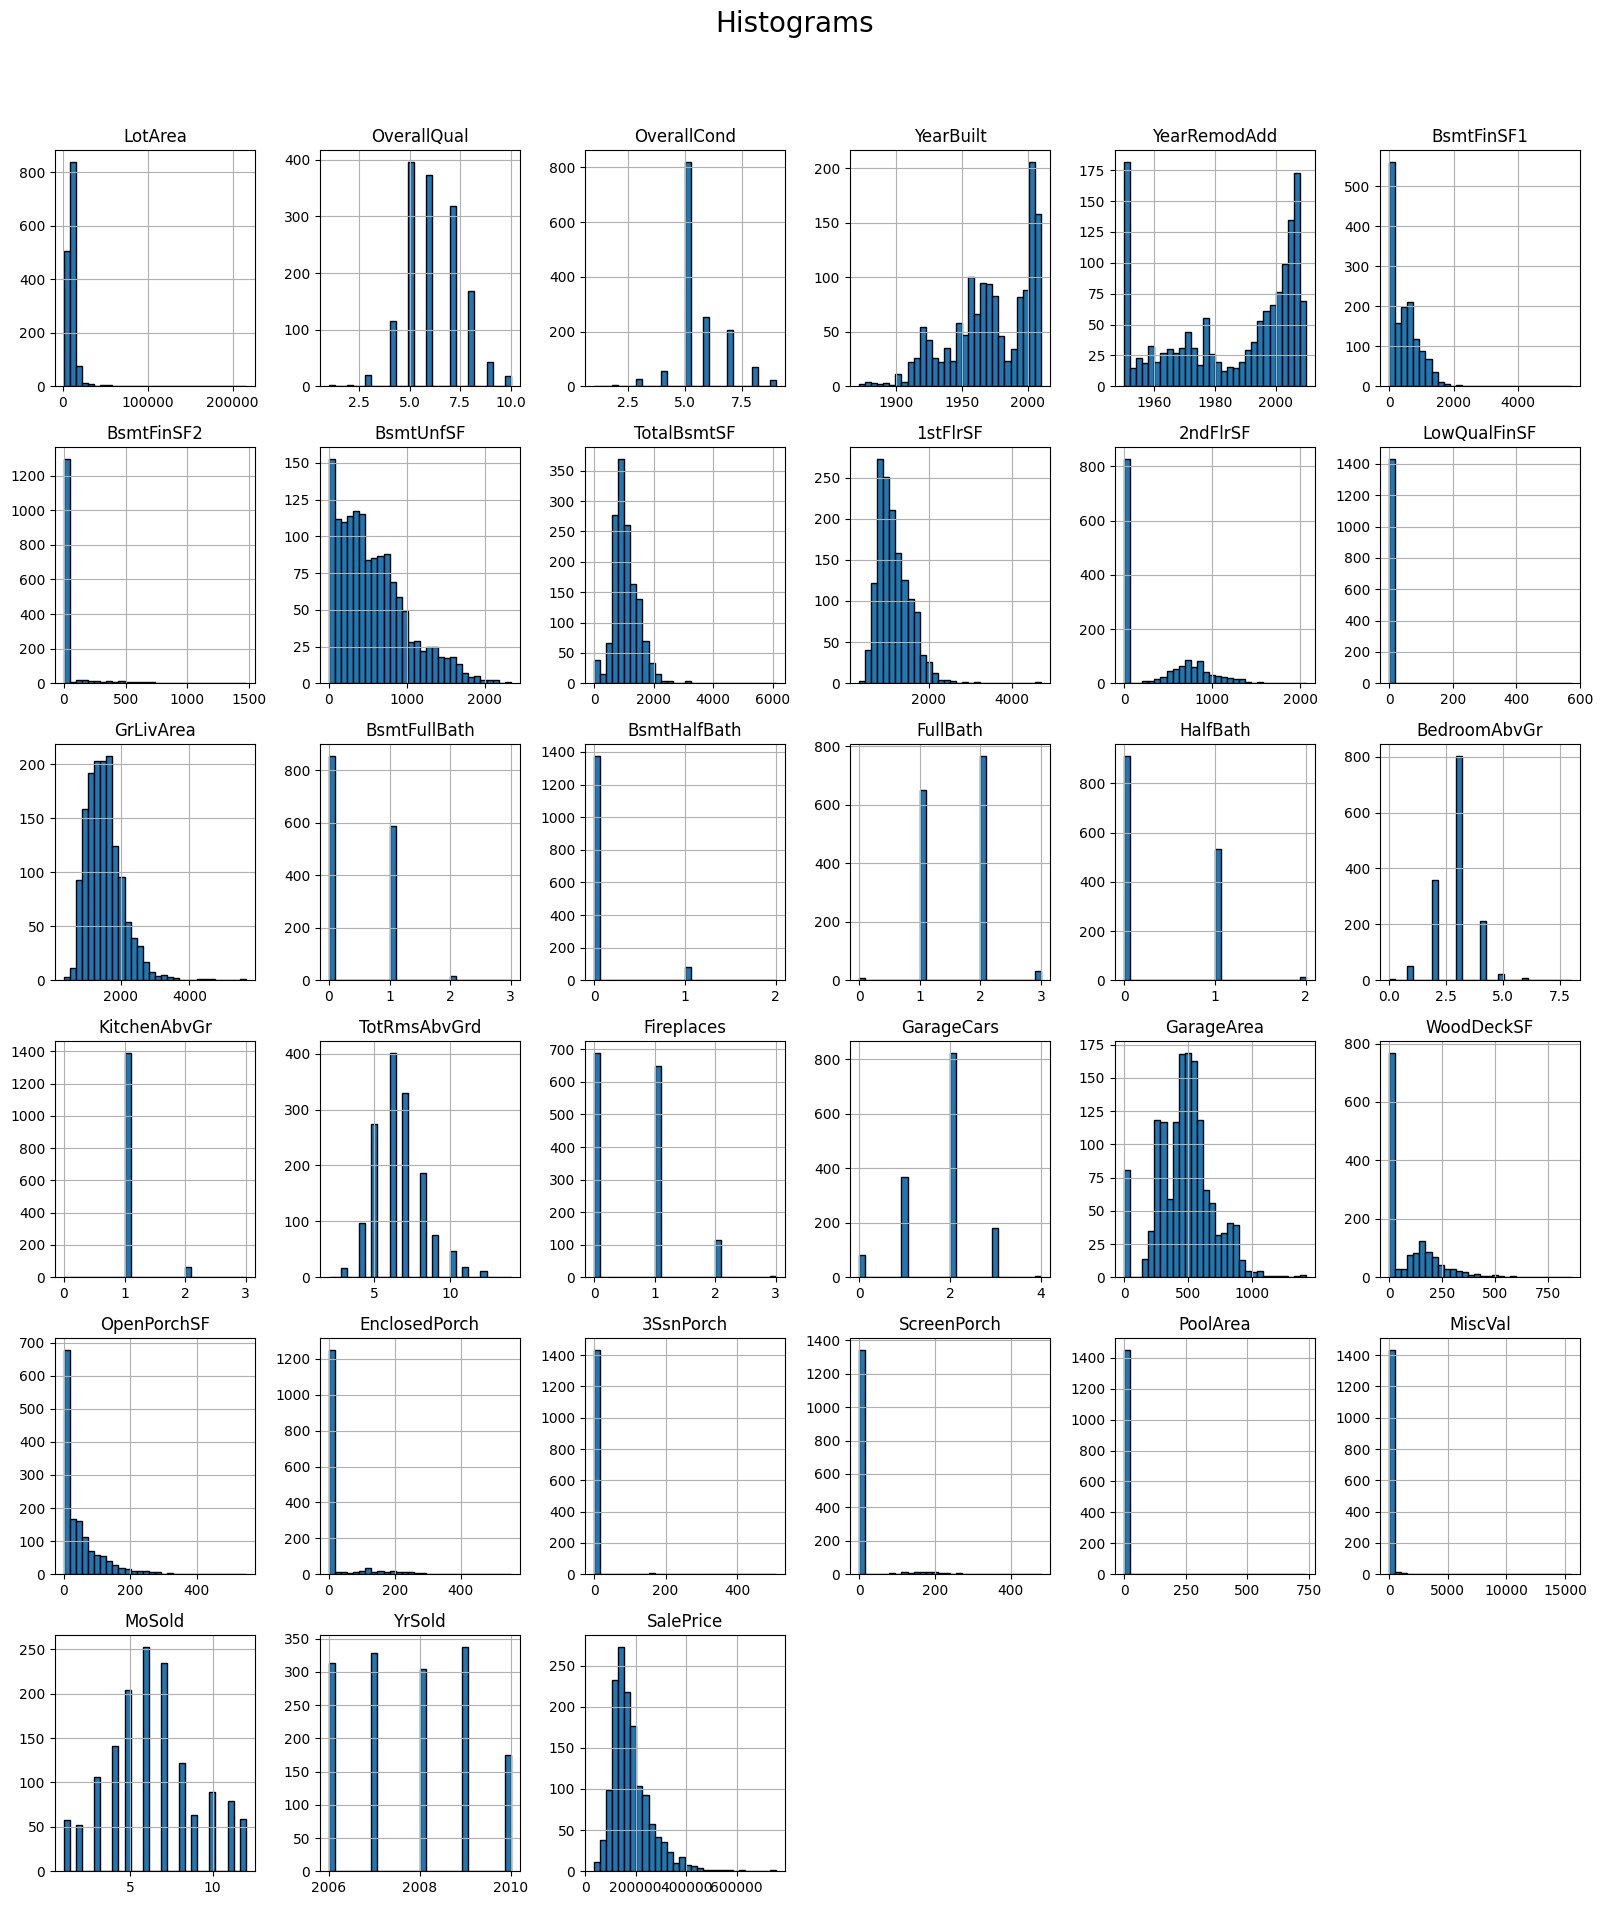

In [1736]:
# Plotting all histograms

features = train_set.iloc[:, 1:]

# figsize scales the plot area; layout automatically arranges the grid
features.hist(figsize=(16, 20), bins=30, edgecolor='black')

plt.suptitle('Histograms', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

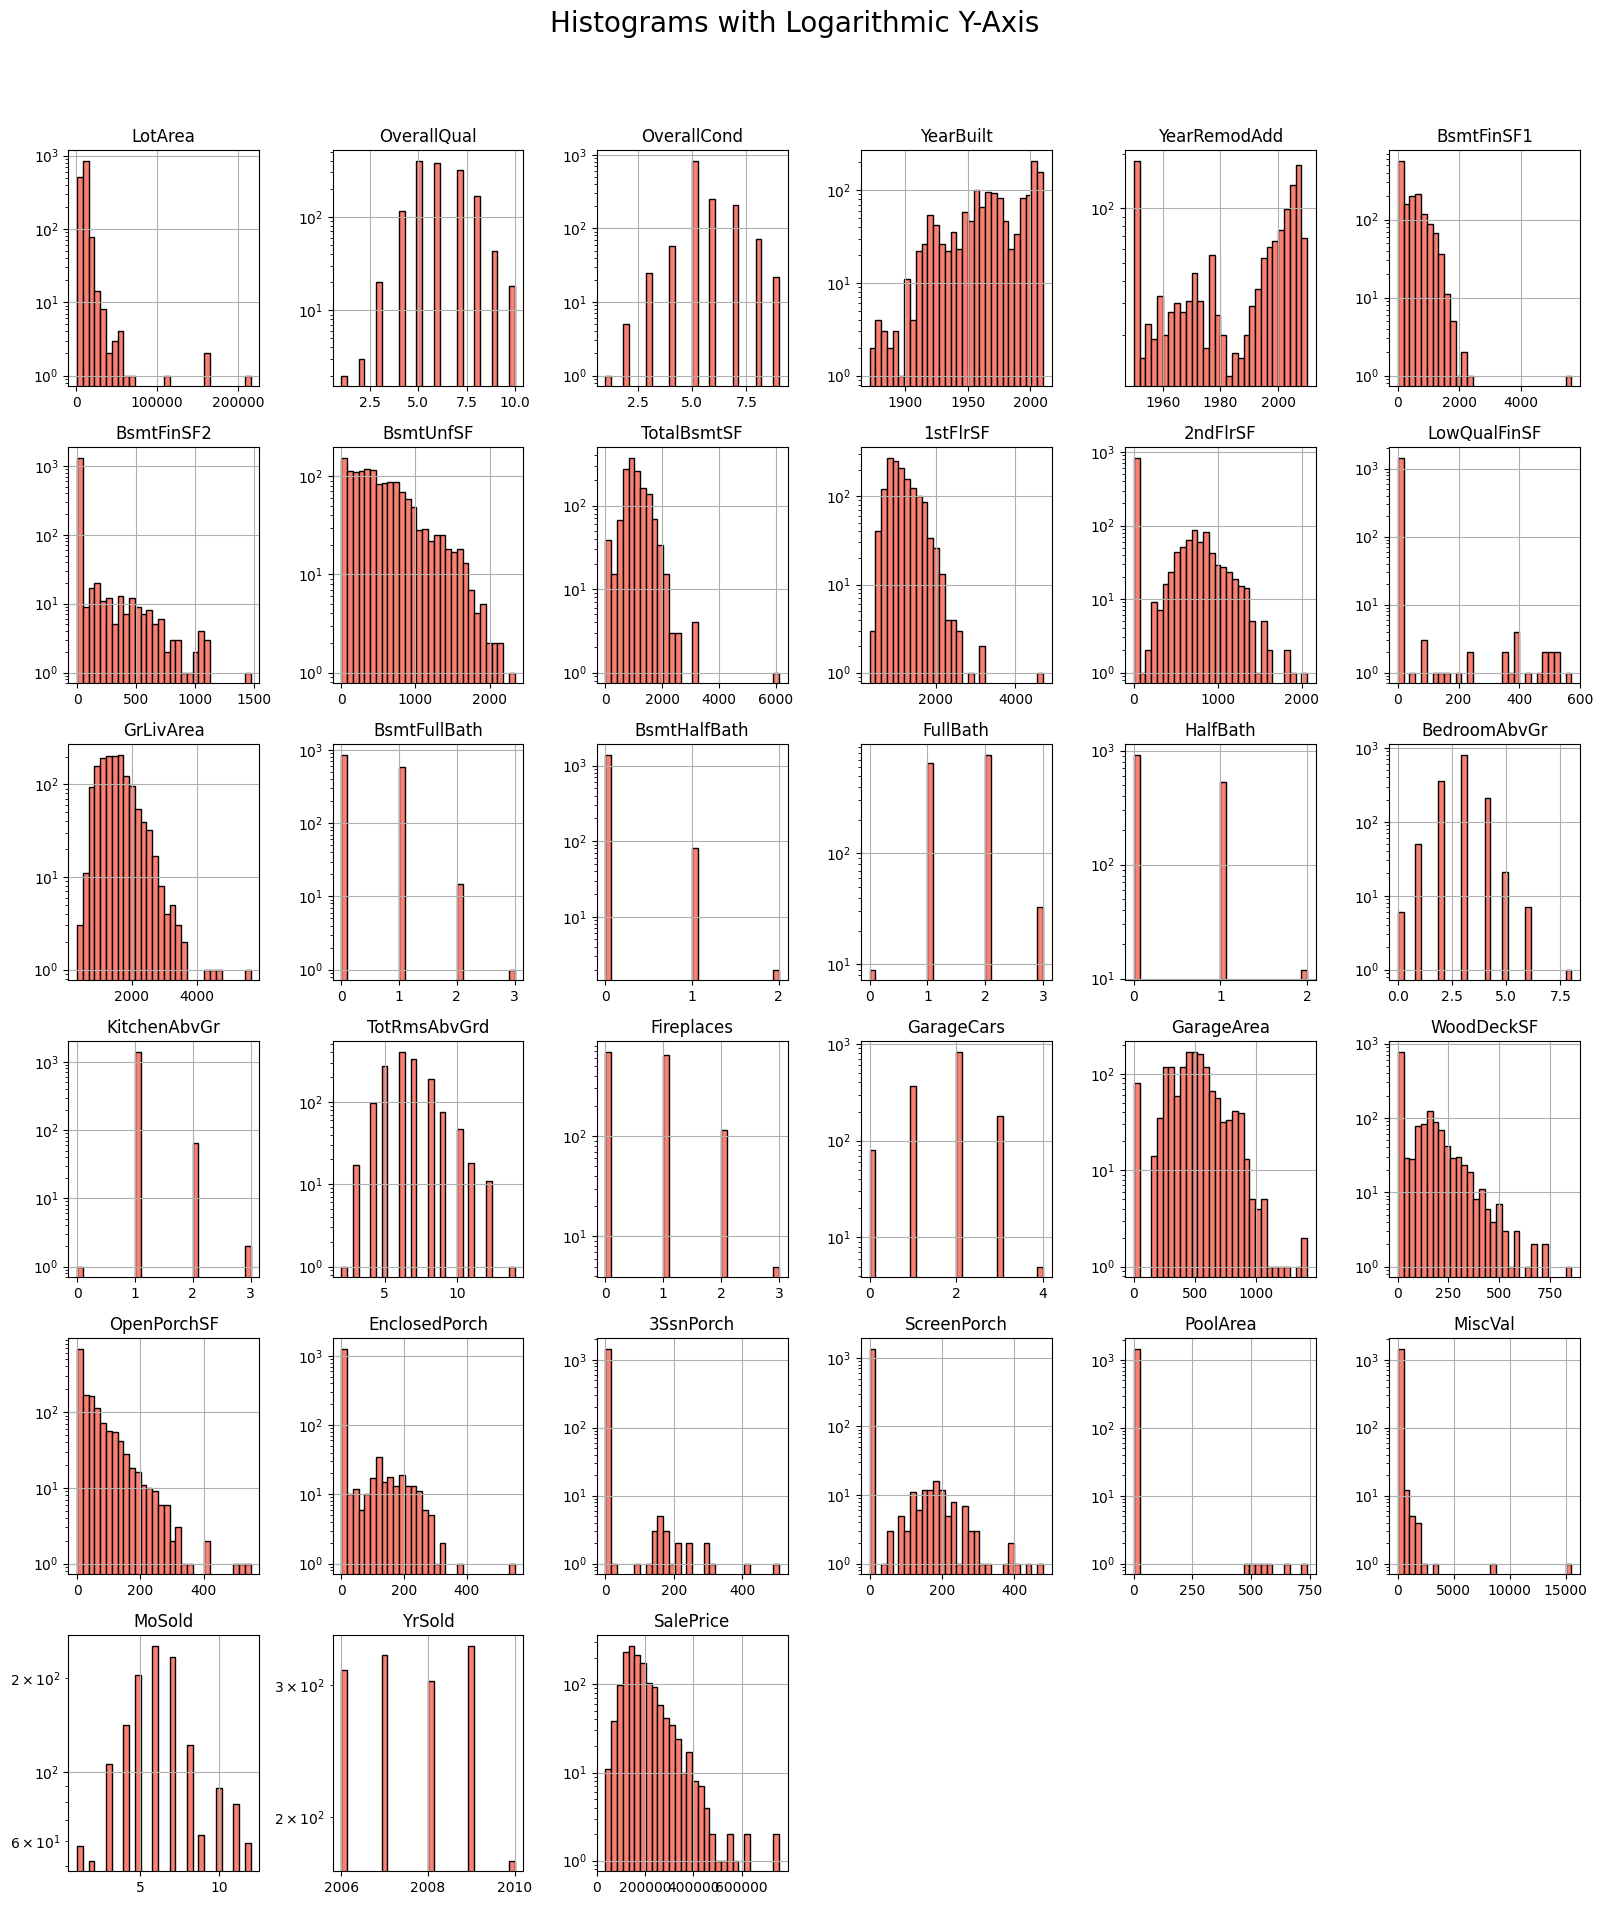

In [1737]:
# plotting histrograms with log(y-axis) to see small values 
#features = train_set.iloc[:, 1:]
features.hist(figsize=(16, 20), bins=30, edgecolor='black', log=True, color='salmon')

plt.suptitle('Histograms with Logarithmic Y-Axis', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [1738]:
############################################################################################
################################## Handling missing data ###################################
############################################################################################

In [1739]:
# Criteria of handling missing data:
#
#    Missing %   Strategy                  Recommended Action
#    0% - 5%     Fast & Simple             Use Simple Imputation (Mean/Median/Mode) or Listwise Deletion 
#                                          (drop the rows). At this low level, the impact on your model 
#                                          is minimal.
#    5% – 30%    Statistical Imputation    Don't drop. Use Predictive Imputation (KNN or MICE) to preserve
#                                          the relationships between variables. Simple Mean/Median might 
#                                          start to "shrink" your variance too much here.
#    30% – 50%   Advanced / Strategic      Use Advanced Imputation and always add a Missingness Indicator 
#                                          (a new binary column that says "Was_Missing: True/False"). This
#                                          tells the model that the absence of data might be a pattern.
#    > 50%       Deletion or Feature Eng.  Generally, Drop the Column. It’s hard to "guess" half of a 
#                                          variable accurately. Only keep it if you believe the fact that 
#                                          it's missing is the most important signal.

# Before starting dealing with the Criteria, CHECK THE FOLLOWING NOTE. 
# NOTE: When a missing value actually represents a specific state (like "No Room," "No Garage," or "No Pool"),
#       it is technically NOT "missing" data. In this specific case, YOU SHOULD NOT DROP THE COLUMN.
#       For categorical columns: fill missing data with the Mode (the most frequent value)
#       For numerical columns: fill missing data with the Median (to avoid outlier influence)

In [1740]:
# **********************************************************************
# IMPORTANT NOTE:  IMPLEMENT THE DATA PREPROCESSING TO THE TEST SET TOO
# **********************************************************************

In [1741]:
# Data cleaning
# Handling Missing Data

# Missing Data statistics

# 1. Create the mask for "NA" (this catches missing values in ALL columns)
missing_mask = (train_set == "NA")

# 2. Calculate statistics
missing_count = missing_mask.sum()
missing_percentage = (missing_count / len(train_set)) * 100
# Use the types from the standard load so numerical columns show as float/int
data_types = train_set_types.dtypes

# 3. Combine into the report
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])

# 4. Sort and filter
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print("--- Real Missing Data Statistics (Numerical & Categorical) ---")
print(missing_only)

--- Real Missing Data Statistics (Numerical & Categorical) ---
              Total Missing  Percent (%)     Type
PoolQC               1453.0    99.520548   object
MiscFeature          1406.0    96.301370   object
Alley                1369.0    93.767123   object
Fence                1179.0    80.753425   object
FireplaceQu           690.0    47.260274   object
LotFrontage           259.0    17.739726  float64
GarageQual             81.0     5.547945   object
GarageYrBlt            81.0     5.547945  float64
GarageType             81.0     5.547945   object
GarageFinish           81.0     5.547945   object
GarageCond             81.0     5.547945   object
BsmtExposure           38.0     2.602740   object
BsmtFinType2           38.0     2.602740   object
BsmtCond               37.0     2.534247   object
BsmtQual               37.0     2.534247   object
BsmtFinType1           37.0     2.534247   object
MasVnrArea              8.0     0.547945  float64
MasVnrType              8.0     0.547

Missing data in PoolQC       => No Pool

Missing data in MiscFeature  => Missing data

Missing data in Alley        => No alley access

Missing data in Fence        => No Fence

Missing data in MasVnrType   => Missing data

Missing data in FireplaceQu  => No Fireplace

Missing data in LotFrontage  => Missing data

Missing data in GarageQual   => No Garage

Missing data in GarageFinish => No Garage

Missing data in GarageType   => No Garage

Missing data in GarageYrBlt  => No Garage

Missing data in GarageCond   => No Garage

Missing data in BsmtFinType2 => No Basement

Missing data in BsmtExposure => No Basement

Missing data in BsmtCond     => No Basement

Missing data in BsmtQual     => No Basement

Missing data in BsmtFinType1 => No Basement

Missing data in MasVnrArea   => Missing data

Missing data in Electrical   => Missing data

Note: 
              Total Missing  Percent (%)     Type
GarageYrBlt              81     5.547945  float64
GarageQual               81     5.547945   object
GarageCond               81     5.547945   object
GarageType               81     5.547945   object
GarageFinish             81     5.547945   object

GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition

These missing data are related to the same readings. there are 81 readings (rows) that have missing GarageYrBlt, GarageQual, GarageCond, GarageType and GarageFinish values .

It is noticed that each one of these 81 readings (appartments) have GarageCars = 0 and GarageArea = 0
this means that these appartments has no garage.

In [1742]:
# Dealing with the 81 appartment that do not have a garage
# For Categorical Columns replace the missing value with string "None"
# For Numerical Columns replace the missing value with string 0 

# 1. Define your column groups
garage_cat_cols = ['GarageQual', 'GarageCond', 'GarageType', 'GarageFinish']
garage_num_cols = ['GarageYrBlt']

# 2. Use .replace() instead of .fillna() because "NA" is a string, not a null object
train_set[garage_cat_cols] = train_set[garage_cat_cols].replace("NA", "None")
train_set[garage_num_cols] = train_set[garage_num_cols].replace("NA", 0)

# 3. Define the mask to verify no "NA" strings remain
missing_mask = (train_set == "NA")

print("Missing values in Garage columns after specific handling:")
# 4. Use the mask to sum the remaining "NA" occurrences
print(missing_mask[garage_cat_cols + garage_num_cols].sum())

Missing values in Garage columns after specific handling:
GarageQual      0
GarageCond      0
GarageType      0
GarageFinish    0
GarageYrBlt     0
dtype: int64


In [1743]:
# Checking the fixing of the appartments that have no garage

# Missing Data statistics

# 1. Create the mask for "NA" (this catches missing values in ALL columns)
missing_mask = (train_set == "NA")

# 2. Calculate statistics
missing_count = missing_mask.sum()
missing_percentage = (missing_count / len(train_set)) * 100
# Use the types from the standard load so numerical columns show as float/int
data_types = train_set_types.dtypes

# 3. Combine into the report
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])

# 4. Sort and filter
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print("--- Real Missing Data Statistics (Numerical & Categorical) ---")
print(missing_only)

--- Real Missing Data Statistics (Numerical & Categorical) ---
              Total Missing  Percent (%)     Type
PoolQC               1453.0    99.520548   object
MiscFeature          1406.0    96.301370   object
Alley                1369.0    93.767123   object
Fence                1179.0    80.753425   object
FireplaceQu           690.0    47.260274   object
LotFrontage           259.0    17.739726  float64
BsmtFinType2           38.0     2.602740   object
BsmtExposure           38.0     2.602740   object
BsmtQual               37.0     2.534247   object
BsmtCond               37.0     2.534247   object
BsmtFinType1           37.0     2.534247   object
MasVnrType              8.0     0.547945   object
MasVnrArea              8.0     0.547945  float64
Electrical              1.0     0.068493   object


Note :
              Total Missing  Percent (%)     Type
BsmtExposure             38     2.602740   object
BsmtFinType2             38     2.602740   object
BsmtCond                 37     2.534247   object
BsmtFinType1             37     2.534247   object
BsmtQual                 37     2.534247   object


BsmtExposure: Walkout or garden level basement walls
       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

BsmtFinType2: Rating of basement finished area (if multiple types) / Quality of second finished area (if present)
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtCond: Evaluates the general condition of the basement
       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

BsmtFinType1: Rating of basement finished area
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtQual: Evaluates the height of the basement
       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement


these indicate that there is 37 appartments have no basement and 1 appartment with undefined BsmtExposure value and undefined BsmtFinType2 value

In [1744]:
# Dealing with the 37 appartments having no basement and 1 appartment with undefined BsmtExposure value 
# and undefined BsmtFinType2 value

bsmt_cols_to_fix = ['BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtFinType1', 'BsmtQual']

train_set[bsmt_cols_to_fix] = train_set[bsmt_cols_to_fix].replace("NA", "None")

# Verify
print("Missing values after update:")
missing_mask = (train_set == "NA")
print(missing_mask[bsmt_cols_to_fix].sum())

Missing values after update:
BsmtExposure    0
BsmtFinType2    0
BsmtCond        0
BsmtFinType1    0
BsmtQual        0
dtype: int64


In [1745]:
# Checking the fixing of the 37 appartments having no basement and 1 appartment with undefined 
# BsmtExposure value and undefined BsmtFinType2 value

# Missing Data statistics

# 1. Create the mask for "NA" (this catches missing values in ALL columns)
missing_mask = (train_set == "NA")

# 2. Calculate statistics
missing_count = missing_mask.sum()
missing_percentage = (missing_count / len(train_set)) * 100
# Use the types from the standard load so numerical columns show as float/int
data_types = train_set_types.dtypes

# 3. Combine into the report
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])

# 4. Sort and filter
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print("--- Real Missing Data Statistics (Numerical & Categorical) ---")
print(missing_only)

--- Real Missing Data Statistics (Numerical & Categorical) ---
             Total Missing  Percent (%)     Type
PoolQC              1453.0    99.520548   object
MiscFeature         1406.0    96.301370   object
Alley               1369.0    93.767123   object
Fence               1179.0    80.753425   object
FireplaceQu          690.0    47.260274   object
LotFrontage          259.0    17.739726  float64
MasVnrType             8.0     0.547945   object
MasVnrArea             8.0     0.547945  float64
Electrical             1.0     0.068493   object


In [1746]:
# Dealing with the other variables that have missing data and their missing data represent a specific state
# (as ex. "No Room")
# These varaibles are : PoolQC, Alley, Fence, FireplaceQu 
# Note that they are categorical data

cat_cols_to_fix = ['PoolQC', 'Alley', 'Fence', 'FireplaceQu']

train_set[cat_cols_to_fix] = train_set[cat_cols_to_fix].replace("NA", "None")

# Verify
print("Missing values after update:")
missing_mask = (train_set == "NA")
print(missing_mask[cat_cols_to_fix].sum())

Missing values after update:
PoolQC         0
Alley          0
Fence          0
FireplaceQu    0
dtype: int64


In [1747]:
# Checking the fixing of the the other variables that have missing data and their missing data represent
# a specific state (as ex. "No Room")

# Missing Data statistics

# 1. Create the mask for "NA" (this catches missing values in ALL columns)
missing_mask = (train_set == "NA")

# 2. Calculate statistics
missing_count = missing_mask.sum()
missing_percentage = (missing_count / len(train_set)) * 100
# Use the types from the standard load so numerical columns show as float/int
data_types = train_set_types.dtypes

# 3. Combine into the report
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])

# 4. Sort and filter
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print("--- Real Missing Data Statistics (Numerical & Categorical) ---")
print(missing_only)

--- Real Missing Data Statistics (Numerical & Categorical) ---
             Total Missing  Percent (%)     Type
MiscFeature         1406.0    96.301370   object
LotFrontage          259.0    17.739726  float64
MasVnrArea             8.0     0.547945  float64
MasVnrType             8.0     0.547945   object
Electrical             1.0     0.068493   object


In [1748]:
# Remove the column with missing data percentage > 50% 

# 1. Create the mask for literal "NA" strings
missing_mask = (train_set == "NA")

# 2. Calculate percentage of "NA" per column
missing_percentage = (missing_mask.sum() / len(train_set)) * 100

# 3. Identify columns where the "NA" count is greater than 50%
cols_to_drop = missing_percentage[missing_percentage > 50].index.tolist()

# 4. Drop the columns from both sets
train_set.drop(columns=cols_to_drop, inplace=True)
test_set.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {cols_to_drop}")

print(f"New shape of train_set: {train_set.shape}")
print(f"New shape of test_set: {test_set.shape}")

Dropped columns: ['MiscFeature']
New shape of train_set: (1460, 79)
New shape of test_set: (1459, 78)


In [1749]:
# Checking the removing of the column with missing data percentage > 50%

# Missing Data statistics

# 1. Create the mask for "NA" (this catches missing values in ALL columns)
missing_mask = (train_set == "NA")

# 2. Calculate statistics
missing_count = missing_mask.sum()
missing_percentage = (missing_count / len(train_set)) * 100
# Use the types from the standard load so numerical columns show as float/int
data_types = train_set_types.dtypes

# 3. Combine into the report
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])

# 4. Sort and filter
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print("--- Real Missing Data Statistics (Numerical & Categorical) ---")
print(missing_only)

--- Real Missing Data Statistics (Numerical & Categorical) ---
             Total Missing  Percent (%)     Type
LotFrontage          259.0    17.739726  float64
MasVnrType             8.0     0.547945   object
MasVnrArea             8.0     0.547945  float64
Electrical             1.0     0.068493   object


In [1750]:
# Dealing with the columns that their missing values are [0% , 5%] of their whole data
# To do:
#     - fill missing data in categorical columns with the Mode (the most frequent value)
#     - fill missing data in numerical columns with the Median (to avoid outlier influence)


# Handling missing data in categorical columns with missing data [0% , 5%]

# 1. Create the mask for the string "NA"
missing_mask = (train_set == "NA")

# 2. Calculate missing percentage based on the mask
missing_pct = (missing_mask.sum() / len(train_set)) * 100

# 3. Identify ONLY truly categorical columns (from train_set_types)
# that STILL EXIST in train_set and have 0% < missing <= 5%
target_categorical_cols = [
    col for col in train_set_types.select_dtypes(include=['object']).columns 
    if col in train_set.columns and 0 < missing_pct[col] <= 5
]

if target_categorical_cols:
    # 4. Use SimpleImputer specifically looking for the "NA" string
    cat_imputer = SimpleImputer(missing_values="NA", strategy='most_frequent')
    train_set[target_categorical_cols] = cat_imputer.fit_transform(train_set[target_categorical_cols])
    
    print(f"Imputed categorical columns: {target_categorical_cols}")
else:
    print("No categorical columns found with 0% to 5% missing data.")

# 5. Verify
remaining_na = (train_set[target_categorical_cols] == "NA").sum().sum()
print(f"Remaining 'NA' values in these columns: {remaining_na}")

Imputed categorical columns: ['MasVnrType', 'Electrical']
Remaining 'NA' values in these columns: 0


In [1751]:
# Checking the fixing of the categorical column with missing data percentage [0% , 5%]

# Missing Data statistics

# 1. Create the mask for "NA" (this catches missing values in ALL columns)
missing_mask = (train_set == "NA")

# 2. Calculate statistics
missing_count = missing_mask.sum()
missing_percentage = (missing_count / len(train_set)) * 100
# Use the types from the standard load so numerical columns show as float/int
data_types = train_set_types.dtypes

# 3. Combine into the report
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])

# 4. Sort and filter
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print("--- Real Missing Data Statistics (Numerical & Categorical) ---")
print(missing_only)

--- Real Missing Data Statistics (Numerical & Categorical) ---
             Total Missing  Percent (%)     Type
LotFrontage          259.0    17.739726  float64
MasVnrArea             8.0     0.547945  float64


In [1752]:
# Handling missing data in numerical columns with missing data [0% , 5%]

# 1. Create the mask for "NA"
missing_mask = (train_set == "NA")

# 2. Identify truly numerical columns (using train_set_types as reference)
true_numerical_cols = train_set_types.select_dtypes(include=['number']).columns

target_numerical_cols = [
    col for col in true_numerical_cols 
    if col in train_set.columns and 0 < missing_mask[col].sum() <= (0.05 * len(train_set))
]

for col in target_numerical_cols:
    # A. Convert column to numeric, turning "NA" into real NaN temporarily
    temp_series = pd.to_numeric(train_set[col], errors='coerce')
    
    # B. Calculate the median of the valid numbers
    median_val = temp_series.median()
    
    # C. Fill the "NA" spots in the original dataframe with that median
    train_set.loc[train_set[col] == "NA", col] = median_val
    
    # D. Ensure the column is now officially a numeric type
    train_set[col] = train_set[col].astype(float)

print(f"Successfully imputed numerical columns: {target_numerical_cols}")

# 3. Verify
remaining_na = (train_set[target_numerical_cols] == "NA").sum().sum()
print(f"Remaining 'NA' values in these columns: {remaining_na}")

Successfully imputed numerical columns: ['MasVnrArea']
Remaining 'NA' values in these columns: 0


In [1753]:
# Checking the fixing of the numerical column with missing data percentage [0% , 5%]
# Missing Data statistics

# 1. Create the mask for "NA" (this catches missing values in ALL columns)
missing_mask = (train_set == "NA")

# 2. Calculate statistics
missing_count = missing_mask.sum()
missing_percentage = (missing_count / len(train_set)) * 100
# Use the types from the standard load so numerical columns show as float/int
data_types = train_set_types.dtypes

# 3. Combine into the report
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])

# 4. Sort and filter
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print("--- Real Missing Data Statistics (Numerical & Categorical) ---")
print(missing_only)

--- Real Missing Data Statistics (Numerical & Categorical) ---
             Total Missing  Percent (%)     Type
LotFrontage          259.0    17.739726  float64


In [1754]:
# Dealing with the columns that their missing values are [5% , 30%] of their whole data

# 1. Define columns and create a working copy
predictive_cols = ['LotFrontage', 'LotArea', 'LotConfig', 'LotShape', 'Neighborhood', 'BldgType', 'MSZoning']
cat_cols = ['LotConfig', 'LotShape', 'Neighborhood', 'BldgType', 'MSZoning']

# Create copy and immediately replace "NA" with np.nan for processing
train_set_sub = train_set[predictive_cols].copy()
train_set_sub = train_set_sub.replace("NA", np.nan)

# 2. Convert Categorical data to Numbers
encoder = OrdinalEncoder()

for col in cat_cols:
    # Use standard .notnull() now because we replaced "NA" with np.nan above
    non_null_mask = train_set_sub[col].notnull()
    if non_null_mask.any():
        reshaped_vals = train_set_sub.loc[non_null_mask, col].values.reshape(-1, 1)
        train_set_sub.loc[non_null_mask, col] = encoder.fit_transform(reshaped_vals)

# 3. Apply Iterative Imputer (MICE)
# Since "NA" is now np.nan, the imputer will work perfectly
mice_imputer = IterativeImputer(random_state=42, max_iter=10, initial_strategy='median')
imputed_data = mice_imputer.fit_transform(train_set_sub)

# 4. Bring the data back and update original
train_set_imputed = pd.DataFrame(imputed_data, columns=predictive_cols, index=train_set.index)

# Update LotFrontage and ensure it is numeric
train_set['LotFrontage'] = train_set_imputed['LotFrontage']

# 5. Verify using your specific mask logic
remaining_na = (train_set['LotFrontage'] == "NA").sum()
print(f"Missing values ('NA') in LotFrontage after MICE: {remaining_na}")

Missing values ('NA') in LotFrontage after MICE: 0


In [1755]:
# Checking the fixing of the column with missing data percentage [5% , 30%]

# Missing Data statistics

# 1. Create the mask for "NA" (this catches missing values in ALL columns)
missing_mask = (train_set == "NA")

# 2. Calculate statistics
missing_count = missing_mask.sum()
missing_percentage = (missing_count / len(train_set)) * 100
# Use the types from the standard load so numerical columns show as float/int
data_types = train_set_types.dtypes

# 3. Combine into the report
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])

# 4. Sort and filter
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print("--- Real Missing Data Statistics (Numerical & Categorical) ---")
print(missing_only)

--- Real Missing Data Statistics (Numerical & Categorical) ---
Empty DataFrame
Columns: [Total Missing, Percent (%), Type]
Index: []


In [1756]:
# Check correlation after imputation
print(train_set[['LotFrontage', 'LotArea']].corr())

             LotFrontage   LotArea
LotFrontage     1.000000  0.508958
LotArea         0.508958  1.000000


A correlation of 0.509 is a very positive sign. It confirms that your MICE imputation was successful and logically consistent. 

In [1757]:
# Sanity Check after imputation, While the correlation looks good, you should check for extreme values. 
# Sometimes predictive models can predict a negative number or a massive outlier if the input data is 
# strange.

print(train_set['LotFrontage'].describe())

count    1460.000000
mean       71.285791
std        23.785529
min        21.000000
25%        60.000000
50%        71.000000
75%        82.000000
max       313.000000
Name: LotFrontage, dtype: float64


The count is exactly 1460, which is the total number of rows in the standard Ames housing dataset. This confirms that 100% of the missing values (the 17%) have been filled.

The Mean and the Median are almost identical, it means your data is symmetrical and well-distributed.

In [1758]:
############################################################################################
######################## Handling Near-Zero Variance (NZV) columns ######################### 
############################################################################################

In [1759]:
# Criteria of Handling Near-Zero Variance (NZV) columns
# 
#    Condition        Data Type     Recommended Action  Why?
#    Variance = 0,    Any           Drop                The column is a constant. It is impossible for a 
#                                                       model to learn from a constant.
#    95% - 99% Same   Categorical   Drop                The rare cases are likely noise or "special cases"
#                                                       that don't help general predictions."
#    95% - 99% Same   Numerical     Binarize (0/1),     Convert it to "Has Feature" vs "No Feature" 
#                                                       (e.g., PoolArea → HasPool)."
#    80% - 95% Same   Categorical   Group "Rare",       Combine all tiny categories into one label called 
#                                                       "Other"
#
#
# for Discrete Columns
#    If the Discrete Column is      Recommended Action  Why?
#    Constant                       Drop                Zero variance; no predictive power.
#    (e.g., all have 1 kitchen)
#    Mostly one value (>95%)        Binarize            Transform into "Has Multiple Kitchens (0 or 1).
#    Small range (e.g., 1 to 4)     Keep as is          The model can handle small integers easily.
#    Large range (e.g., YearBuilt)  Feature Engineer,   Convert to "Age of House" (Current Year - YearBuilt).

In [1760]:
# ------------------------ For categorical columns ------------------------
# Getting Frequency Ratio (the percentage of the most common value) of categorical columns

cat_cols = train_set.select_dtypes(include=['object', 'category']).columns
frequency_data = []

for col in cat_cols:
    value_counts = train_set[col].value_counts(normalize=True)
    
    if not value_counts.empty:
        most_common_val = value_counts.index[0]
        most_common_pct = value_counts.iloc[0] * 100
        
        frequency_data.append({
            'Column': col,
            'Most Common Value': most_common_val,
            'Frequency Ratio (%)': round(most_common_pct, 2)
        })

frequency_df = pd.DataFrame(frequency_data).sort_values(by='Frequency Ratio (%)', ascending=False)

print("Categorical Columns with High Imbalance (>80%):")
print(frequency_df[frequency_df['Frequency Ratio (%)'] > 80])

Categorical Columns with High Imbalance (>80%):
           Column Most Common Value  Frequency Ratio (%)
5       Utilities            AllPub                99.93
1          Street              Pave                99.59
39         PoolQC              None                99.52
10     Condition2              Norm                98.97
14       RoofMatl           CompShg                98.22
26        Heating              GasA                97.81
7       LandSlope               Gtl                94.66
2           Alley              None                93.77
28     CentralAir                 Y                93.49
31     Functional               Typ                93.15
38     PavedDrive                 Y                91.78
29     Electrical             SBrkr                91.44
37     GarageCond                TA                90.82
22       BsmtCond                TA                89.79
36     GarageQual                TA                89.79
4     LandContour               Lvl     

In [1761]:
# Droping the columns with Frequency Ratio > 95%

def drop_high_imbalance_cats(df, threshold=95.0):
    """
    Identifies and drops categorical columns where the most frequent 
    value exceeds the given percentage threshold.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    cols_to_drop = []

    print(f"Checking {len(cat_cols)} categorical columns for imbalance > {threshold}%...\n")

    for col in cat_cols:
        value_counts = df[col].value_counts(normalize=True)
        
        if not value_counts.empty:
            most_freq_pct = value_counts.iloc[0] * 100
            
            if most_freq_pct > threshold:
                print(f"DROPPING: [{col}] - Most frequent value: '{value_counts.index[0]}' ({most_freq_pct:.2f}%)")
                cols_to_drop.append(col)

    df_cleaned = df.drop(columns=cols_to_drop)
    
    print(f"\nSuccessfully dropped {len(cols_to_drop)} columns.")
    print(f"Remaining columns: {df_cleaned.shape[1]}")
    
    return df_cleaned, cols_to_drop

train_set, dropped_list = drop_high_imbalance_cats(train_set, threshold=95.0)

# Apply the same drops to your test set
test_set = test_set.drop(columns=dropped_list)

print(f"New shape of train_set: {train_set.shape}")
print(f"New shape of test_set: {test_set.shape}")

Checking 43 categorical columns for imbalance > 95.0%...

DROPPING: [Street] - Most frequent value: 'Pave' (99.59%)
DROPPING: [Utilities] - Most frequent value: 'AllPub' (99.93%)
DROPPING: [Condition2] - Most frequent value: 'Norm' (98.97%)
DROPPING: [RoofMatl] - Most frequent value: 'CompShg' (98.22%)
DROPPING: [Heating] - Most frequent value: 'GasA' (97.81%)
DROPPING: [PoolQC] - Most frequent value: 'None' (99.52%)

Successfully dropped 6 columns.
Remaining columns: 73
New shape of train_set: (1460, 73)
New shape of test_set: (1459, 72)


In [1762]:
# Checking after droping the columns with Frequency Ratio > 95%

cat_cols = train_set.select_dtypes(include=['object', 'category']).columns
frequency_data = []

for col in cat_cols:
    value_counts = train_set[col].value_counts(normalize=True)
    
    if not value_counts.empty:
        most_common_val = value_counts.index[0]
        most_common_pct = value_counts.iloc[0] * 100
        
        frequency_data.append({
            'Column': col,
            'Most Common Value': most_common_val,
            'Frequency Ratio (%)': round(most_common_pct, 2)
        })

frequency_df = pd.DataFrame(frequency_data).sort_values(by='Frequency Ratio (%)', ascending=False)

print("Categorical Columns with High Imbalance (>80%):")
print(frequency_df[frequency_df['Frequency Ratio (%)'] > 80])

Categorical Columns with High Imbalance (>80%):
           Column Most Common Value  Frequency Ratio (%)
5       LandSlope               Gtl                94.66
1           Alley              None                93.77
23     CentralAir                 Y                93.49
26     Functional               Typ                93.15
33     PavedDrive                 Y                91.78
24     Electrical             SBrkr                91.44
32     GarageCond                TA                90.82
31     GarageQual                TA                89.79
3     LandContour               Lvl                89.79
18       BsmtCond                TA                89.79
15      ExterCond                TA                87.81
35       SaleType                WD                86.78
7      Condition1              Norm                86.30
21   BsmtFinType2               Unf                86.03
8        BldgType              1Fam                83.56
36  SaleCondition            Normal     

Regarding the next step: for Categorical with 80% - 95% of their values are same -> Combine all tiny categories into one label called "Other"

CentralAir: Central air conditioning already has two values (N -> No and Y -> Yes), so it can be excluded.

In [1763]:
# For Categorical with 80% - 95% of their values are same -> Combine all tiny categories into one label
# called "Other"

def group_rare_categories(df, lower_thresh=80.0, upper_thresh=95.0):
    """
    Groups minority categories into 'Other' for columns where the 
    majority value is between 80% and 95%.
    Excludes binary columns (columns with only 2 unique values).
    """
    # 1. Identify categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    print(f"Analyzing columns for grouping (Threshold: {lower_thresh}% - {upper_thresh}%)...\n")

    for col in cat_cols:
        # Get number of unique values
        unique_count = df[col].nunique()
        
        # Skip binary columns (like CentralAir)
        if unique_count <= 2:
            continue
            
        # Get the frequency of the most common value
        value_counts_pct = df[col].value_counts(normalize=True) * 100
        most_freq_pct = value_counts_pct.iloc[0]
        
        # Check if it falls within the 80% - 95% range
        if lower_thresh <= most_freq_pct < upper_thresh:
            most_common_label = value_counts_pct.index[0]
            
            # Identify the "tiny" labels (everything except the most common one)
            # We replace them with 'Other'
            df[col] = df[col].apply(lambda x: x if x == most_common_label else 'Other')
            
            print(f"GROUPED: [{col}] - Kept '{most_common_label}', grouped others into 'Other'.")
            
    return df

# Execution
train_set = group_rare_categories(train_set)

Analyzing columns for grouping (Threshold: 80.0% - 95.0%)...

GROUPED: [Alley] - Kept 'None', grouped others into 'Other'.
GROUPED: [LandContour] - Kept 'Lvl', grouped others into 'Other'.
GROUPED: [LandSlope] - Kept 'Gtl', grouped others into 'Other'.
GROUPED: [Condition1] - Kept 'Norm', grouped others into 'Other'.
GROUPED: [BldgType] - Kept '1Fam', grouped others into 'Other'.
GROUPED: [ExterCond] - Kept 'TA', grouped others into 'Other'.
GROUPED: [BsmtCond] - Kept 'TA', grouped others into 'Other'.
GROUPED: [BsmtFinType2] - Kept 'Unf', grouped others into 'Other'.
GROUPED: [Electrical] - Kept 'SBrkr', grouped others into 'Other'.
GROUPED: [Functional] - Kept 'Typ', grouped others into 'Other'.
GROUPED: [GarageQual] - Kept 'TA', grouped others into 'Other'.
GROUPED: [GarageCond] - Kept 'TA', grouped others into 'Other'.
GROUPED: [PavedDrive] - Kept 'Y', grouped others into 'Other'.
GROUPED: [Fence] - Kept 'None', grouped others into 'Other'.
GROUPED: [SaleType] - Kept 'WD', grouped 

In [1764]:
# Checking for Categorical with 80% - 95% of their values are same after Combine all tiny categories into
# one label

def check_grouping_results(df, lower_thresh=80.0, upper_thresh=95.0):
    """
    Identifies columns that fit the 80-95% majority criteria, 
    displays their new values ('Majority' vs 'Other'), and their percentages.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    results_found = False

    print(f"{'Column Name':<20} | {'Value':<15} | {'Percentage'}")
    print("-" * 50)

    for col in cat_cols:
        # Skip binary columns (like CentralAir)
        if df[col].nunique() <= 2 and 'Other' not in df[col].values:
            continue
            
        # Check value counts
        counts_pct = df[col].value_counts(normalize=True) * 100
        
        # We look for columns where the top value is 80-95%
        # AND it has an 'Other' category (meaning grouping happened)
        if lower_thresh <= counts_pct.iloc[0] < upper_thresh and 'Other' in counts_pct.index:
            results_found = True
            for val, pct in counts_pct.items():
                print(f"{col:<20} | {val:<15} | {pct:.2f}%")
            print("-" * 50)

    if not results_found:
        print("No columns found matching the grouping criteria. Did you run the grouping function first?")

# Run the check
check_grouping_results(train_set)

Column Name          | Value           | Percentage
--------------------------------------------------
Alley                | None            | 93.77%
Alley                | Other           | 6.23%
--------------------------------------------------
LandContour          | Lvl             | 89.79%
LandContour          | Other           | 10.21%
--------------------------------------------------
LandSlope            | Gtl             | 94.66%
LandSlope            | Other           | 5.34%
--------------------------------------------------
Condition1           | Norm            | 86.30%
Condition1           | Other           | 13.70%
--------------------------------------------------
BldgType             | 1Fam            | 83.56%
BldgType             | Other           | 16.44%
--------------------------------------------------
ExterCond            | TA              | 87.81%
ExterCond            | Other           | 12.19%
--------------------------------------------------
BsmtCond         

In [1765]:
# ------------------------ For numerical Discrete columns ------------------------
#
#    Scenario               Majority Value %   Recommended Action
#    Constant               100%	              Drop (Always)
#    Extremely Imbalanced   96% - 99%	      Drop (Almost always)
#    Highly Imbalanced      90% - 95%	      Binarize
#    Moderately Imbalanced  70% - 89%	      Keep but group rare categories into "Other"

# Getting Discrete Columns Frequency Report

numeric_cols = train_set.select_dtypes(include=['number']).columns
discrete_cols = [col for col in numeric_cols if train_set[col].nunique() < 20]

discrete_summary = []

for col in discrete_cols:
    counts_pct = train_set[col].value_counts(normalize=True) * 100
    
    most_freq_val = counts_pct.index[0]
    most_freq_pct = counts_pct.iloc[0]
    num_unique = train_set[col].nunique()
    
    discrete_summary.append({
        'Column': col,
        'Most Frequent Value': most_freq_val,
        'Frequency (%)': round(most_freq_pct, 2),
        'Unique Values': num_unique
    })

discrete_df = pd.DataFrame(discrete_summary).sort_values(by='Frequency (%)', ascending=False)

print("--- Discrete Columns Frequency Report ---")
print(discrete_df)

# Highlight potential Near-Zero Variance issues (> 95%)
nzv_discrete = discrete_df[discrete_df['Frequency (%)'] > 95]
if not nzv_discrete.empty:
    print("\nWarning: These discrete columns are >95% identical and may need Binarization or Dropping:")
    print(nzv_discrete['Column'].tolist())

--- Discrete Columns Frequency Report ---
          Column  Most Frequent Value  Frequency (%)  Unique Values
12      PoolArea                    0          99.52              8
8   KitchenAbvGr                    1          95.34              4
4   BsmtHalfBath                    0          94.38              3
6       HalfBath                    0          62.53              3
3   BsmtFullBath                    0          58.63              4
11    GarageCars                    2          56.44              5
2    OverallCond                    5          56.23              9
7   BedroomAbvGr                    3          55.07              8
5       FullBath                    2          52.60              4
10    Fireplaces                    0          47.26              4
0     MSSubClass                   20          36.71             15
9   TotRmsAbvGrd                    6          27.53             12
1    OverallQual                    5          27.19             10
14    

In [1766]:
# Drop the discrete columns with frequency > 95%

def drop_nzv_discrete(df, unique_thresh=20, freq_thresh=95.0):
    """
    Identifies discrete numerical columns and drops them if the 
    most frequent value exceeds freq_thresh.
    """
    
    numeric_cols = df.select_dtypes(include=['number']).columns
    cols_to_drop = []

    print(f"Scanning discrete columns for imbalance > {freq_thresh}%...")

    for col in numeric_cols:
        # Define 'Discrete' as having fewer than 'unique_thresh' unique values
        if df[col].nunique() < unique_thresh:
            # Calculate frequency of the most common value
            counts_pct = df[col].value_counts(normalize=True) * 100
            most_freq_pct = counts_pct.iloc[0]
            
            if most_freq_pct > freq_thresh:
                print(f"DROPPING: [{col}] - Most common value '{counts_pct.index[0]}' appears {most_freq_pct:.2f}% of the time.")
                cols_to_drop.append(col)

    
    df_cleaned = df.drop(columns=cols_to_drop)
    
    print(f"\nSuccessfully dropped {len(cols_to_drop)} discrete columns.")
    return df_cleaned, cols_to_drop

train_set, dropped_discrete_list = drop_nzv_discrete(train_set)

# Apply the exact same drops to the test set
test_set = test_set.drop(columns=dropped_discrete_list)


print(f"New shape of train_set: {train_set.shape}")
print(f"New shape of test_set: {test_set.shape}")

Scanning discrete columns for imbalance > 95.0%...
DROPPING: [KitchenAbvGr] - Most common value '1' appears 95.34% of the time.
DROPPING: [PoolArea] - Most common value '0' appears 99.52% of the time.

Successfully dropped 2 discrete columns.
New shape of train_set: (1460, 71)
New shape of test_set: (1459, 70)


In [1767]:
# Checking the drop the discrete columns with frequency > 95%
numeric_cols = train_set.select_dtypes(include=['number']).columns
discrete_cols = [col for col in numeric_cols if train_set[col].nunique() < 20]

discrete_summary = []

for col in discrete_cols:
    counts_pct = train_set[col].value_counts(normalize=True) * 100
    
    most_freq_val = counts_pct.index[0]
    most_freq_pct = counts_pct.iloc[0]
    num_unique = train_set[col].nunique()
    
    discrete_summary.append({
        'Column': col,
        'Most Frequent Value': most_freq_val,
        'Frequency (%)': round(most_freq_pct, 2),
        'Unique Values': num_unique
    })

discrete_df = pd.DataFrame(discrete_summary).sort_values(by='Frequency (%)', ascending=False)

print("--- Discrete Columns Frequency Report ---")
print(discrete_df)

# Highlight potential Near-Zero Variance issues (> 95%)
nzv_discrete = discrete_df[discrete_df['Frequency (%)'] > 95]
if not nzv_discrete.empty:
    print("\nWarning: These discrete columns are >95% identical and may need Binarization or Dropping:")
    print(nzv_discrete['Column'].tolist())

--- Discrete Columns Frequency Report ---
          Column  Most Frequent Value  Frequency (%)  Unique Values
4   BsmtHalfBath                    0          94.38              3
6       HalfBath                    0          62.53              3
3   BsmtFullBath                    0          58.63              4
10    GarageCars                    2          56.44              5
2    OverallCond                    5          56.23              9
7   BedroomAbvGr                    3          55.07              8
5       FullBath                    2          52.60              4
9     Fireplaces                    0          47.26              4
0     MSSubClass                   20          36.71             15
8   TotRmsAbvGrd                    6          27.53             12
1    OverallQual                    5          27.19             10
12        YrSold                 2009          23.15              5
11        MoSold                    6          17.33             12


In [1768]:
# Binarize the discrete columns where the most frequent value is between 90% and 95%

binarization_map = {} # This will store {column_name: majority_value}
numeric_cols = train_set.select_dtypes(include=['number']).columns

for col in numeric_cols:
    # Filter for discrete (less than 20 unique values)
    if train_set[col].nunique() < 20:
        counts_pct = train_set[col].value_counts(normalize=True) * 100
        most_freq_pct = counts_pct.iloc[0]
        
        # Target the 90% - 95% range
        if 90.0 <= most_freq_pct <= 95.0:
            binarization_map[col] = train_set[col].mode()[0]

# --- STEP 2: Apply the Binarization to both Train and Test ---
def apply_binarization(df, mapping):
    df_copy = df.copy()
    for col, maj_val in mapping.items():
        if col in df_copy.columns:
            new_col_name = f"{col}_is_{maj_val}"
            # Create binary flag: 1 if it matches training majority, 0 otherwise
            df_copy[new_col_name] = (df_copy[col] == maj_val).astype(int)
            # Drop original
            df_copy.drop(columns=[col], inplace=True)
            print(f"Processed {col}: Created {new_col_name}")
    return df_copy

# Execute the transformation
train_set = apply_binarization(train_set, binarization_map)
test_set = apply_binarization(test_set, binarization_map)

Processed BsmtHalfBath: Created BsmtHalfBath_is_0
Processed BsmtHalfBath: Created BsmtHalfBath_is_0


In [1769]:
print(train_set.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'Fence', 'MiscVal', '

In [1770]:
train_set.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BsmtHalfBath_is_0
0,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,None,0,2,2008,WD,Normal,208500,1
1,20,RL,80.0,9600,None,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,None,0,5,2007,WD,Normal,181500,0
2,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,None,0,9,2008,WD,Normal,223500,1
3,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,...,0,0,None,0,2,2006,WD,Other,140000,1
4,60,RL,84.0,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,None,0,12,2008,WD,Normal,250000,1


In [1771]:
# Moving 'SalePrice' column to be the last column in the train_set

cols = list(train_set.columns)
cols.remove('SalePrice')
cols.append('SalePrice')
train_set = train_set[cols]

# Check the last 5 columns to verify
print(train_set.iloc[:, -5:].columns)

Index(['YrSold', 'SaleType', 'SaleCondition', 'BsmtHalfBath_is_0',
       'SalePrice'],
      dtype='object')


In [1772]:
train_set.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BsmtHalfBath_is_0,SalePrice
0,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,None,0,2,2008,WD,Normal,1,208500
1,20,RL,80.0,9600,None,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,None,0,5,2007,WD,Normal,0,181500
2,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,None,0,9,2008,WD,Normal,1,223500
3,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,...,0,0,None,0,2,2006,WD,Other,1,140000
4,60,RL,84.0,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,None,0,12,2008,WD,Normal,1,250000


In [1773]:
test_set.head()

,Id,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BsmtHalfBath_is_0
0,1461,RH,80,11622,NA,Reg,Lvl,Inside,Gtl,NAmes,...,0,0,120,MnPrv,0,6,2010,WD,Normal,0
1,1462,RL,81,14267,NA,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,0,NA,12500,6,2010,WD,Normal,0
2,1463,RL,74,13830,NA,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,0,MnPrv,0,3,2010,WD,Normal,0
3,1464,RL,78,9978,NA,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,0,NA,0,6,2010,WD,Normal,0
4,1465,RL,43,5005,NA,IR1,HLS,Inside,Gtl,StoneBr,...,0,0,144,NA,0,1,2010,WD,Normal,0


In [1774]:
# ------------------------ For numerical continuous columns ------------------------
# For numerical continuous columns, the variance is naturally huge because the numbers are large. Instead,
# the gold standard for starting with continuous data is Skewness and Outlier Detection.
# So we work on it in the "Dealing with Outliers" step

In [1775]:
############################################################################################
################################## Dealing with Outliers ###################################
############################################################################################

In [1776]:
# Fixing GarageYrBlt "During handling missing value process, missing values in GarageYrBlt are replaced with zero"
# this creates an outlier 

# Solution: Spliting the information into two parts:
#              A Binary Feature: Has_Garage (1 if it has one, 0 if not).
#              A Cleaned Numerical Feature: We replace the 0 with a value that doesn't "stretch" the math, like the Median or the GarageYrBlt.


# 1. Force the columns to be numeric (NA strings become NaN)
train_garage_yr = pd.to_numeric(train_set['GarageYrBlt'], errors='coerce')
test_garage_yr = pd.to_numeric(test_set['GarageYrBlt'], errors='coerce')

# 2. Create the binary indicator
# We check for values that are NOT 0 and NOT NaN
train_set['Has_Garage'] = ((train_garage_yr != 0) & (train_garage_yr.notnull())).astype(int)
test_set['Has_Garage'] = ((test_garage_yr != 0) & (test_garage_yr.notnull())).astype(int)

# 3. Calculate the Median Year from valid years (ignoring 0 and NaN)
garage_median = train_garage_yr[train_garage_yr > 0].median()

# 4. Fill the original column: Replace 0 and "NA" with the median
# First, update the numeric series
train_garage_yr = train_garage_yr.replace(0, garage_median).fillna(garage_median)
test_garage_yr = test_garage_yr.replace(0, garage_median).fillna(garage_median)

# 5. Put the cleaned numeric data back into the main dataframes
train_set['GarageYrBlt'] = train_garage_yr
test_set['GarageYrBlt'] = test_garage_yr

print(f"Fixed GarageYrBlt: Zeros and 'NA' replaced with median year ({garage_median}).")

Fixed GarageYrBlt: Zeros and 'NA' replaced with median year (1980.0).


In [1777]:
# ------------------------ For categorical columns ------------------------
# Categorical outliers are values that appear so infrequently (e.g., only 1 or 2 times in 1,460 rows)

# Identifying Categorical Outliers
# This code will scan all your categorical columns and list any categories that are "rare" (appearing
# in less than 2.5% of the houses)

def find_categorical_outliers(df, threshold=0.025):
    """
    Identifies rare categories in categorical columns.
    threshold=0.01 means categories appearing in less than 1% of rows.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    rare_report = []

    for col in cat_cols:
        counts = df[col].value_counts(normalize=True)
        # Find labels below the threshold
        rare_labels = counts[counts < threshold].index.tolist()
        
        if rare_labels:
            rare_report.append({
                'Column': col,
                'Rare Categories': rare_labels,
                'Total Rare %': round(counts[rare_labels].sum() * 100, 2)
            })

    return pd.DataFrame(rare_report)

# Run the report
cat_outliers = find_categorical_outliers(train_set)
print("--- Categorical Outlier (Rare Label) Report ---")
print(cat_outliers)

--- Categorical Outlier (Rare Label) Report ---
          Column                                    Rare Categories  \
0       MSZoning                                      [RH, C (all)]   
1       LotShape                                              [IR3]   
2      LotConfig                                              [FR3]   
3   Neighborhood  [ClearCr, SWISU, StoneBr, Blmngtn, MeadowV, Br...   
4     HouseStyle                           [1.5Unf, 2.5Unf, 2.5Fin]   
5      RoofStyle                     [Flat, Gambrel, Mansard, Shed]   
6    Exterior1st  [WdShing, Stucco, AsbShng, BrkComm, Stone, Asp...   
7    Exterior2nd  [Stucco, BrkFace, AsbShng, ImStucc, Brk Cmn, S...   
8     MasVnrType                                           [BrkCmn]   
9      ExterQual                                               [Fa]   
10    Foundation                                [Slab, Stone, Wood]   
11      BsmtQual                                               [Fa]   
12     HeatingQC             

In [1778]:
# Recommended Action Plan
#
#    Total Rare %   Logic                                   Suggested Action
#    Below 0.5%     Too rare to be useful                   Replace with the Mode (the most common value) or group into 'Other'.
#    0.5% to 2.5%   Significant enough to keep but risky    Group into 'Other' so the model sees a larger, more stable "Non-Standard" group.

In [1779]:
# This code handles both groups correctly:
#      1 - Ultra-Rare (< 0.5%): Replaced with the Mode (Noise reduction).
#      2 - Medium-Rare (0.5% to 2.5%): Grouped into 'Other' (Pattern preservation).

def handle_categorical_outliers(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()
    cat_cols = train_df.select_dtypes(include=['object', 'category']).columns

    for col in cat_cols:
        counts = train_df[col].value_counts(normalize=True)
        
        # 1. Handle Ultra-Rare (< 0.5%) -> Replace with Mode
        ultra_rare = counts[counts < 0.005].index.tolist()
        if ultra_rare:
            mode_val = train_df[col].mode()[0]
            train_df[col] = train_df[col].replace(ultra_rare, mode_val)
            test_df[col] = test_df[col].replace(ultra_rare, mode_val)
            print(f"[{col}]: Absorbed {ultra_rare} into Mode ({mode_val})")

        # 2. Re-calculate counts after Mode replacement
        new_counts = train_df[col].value_counts(normalize=True)
        
        # 3. Handle Medium-Rare (0.5% to 2.5%) -> Group as 'Other'
        # We only do this if there are at least 2 categories to group
        medium_rare = new_counts[(new_counts >= 0.005) & (new_counts <= 0.025)].index.tolist()
        
        if medium_rare:
            train_df[col] = train_df[col].replace(medium_rare, 'Other')
            test_df[col] = test_df[col].replace(medium_rare, 'Other')
            print(f"[{col}]: Grouped {medium_rare} into 'Other'")

    return train_df, test_df

# Execute
train_set, test_set = handle_categorical_outliers(train_set, test_set)

[MSZoning]: Grouped ['RH', 'C (all)'] into 'Other'
[LotShape]: Grouped ['IR3'] into 'Other'
[LotConfig]: Absorbed ['FR3'] into Mode (Inside)
[Neighborhood]: Absorbed ['Blueste'] into Mode (NAmes)
[Neighborhood]: Grouped ['ClearCr', 'SWISU', 'StoneBr', 'MeadowV', 'Blmngtn', 'BrDale', 'Veenker', 'NPkVill'] into 'Other'
[HouseStyle]: Grouped ['1.5Unf', '2.5Unf', '2.5Fin'] into 'Other'
[RoofStyle]: Absorbed ['Mansard', 'Shed'] into Mode (Gable)
[RoofStyle]: Grouped ['Flat', 'Gambrel'] into 'Other'
[Exterior1st]: Absorbed ['BrkComm', 'Stone', 'AsphShn', 'ImStucc', 'CBlock'] into Mode (VinylSd)
[Exterior1st]: Grouped ['WdShing', 'Stucco', 'AsbShng'] into 'Other'
[Exterior2nd]: Absorbed ['Brk Cmn', 'Stone', 'AsphShn', 'Other', 'CBlock'] into Mode (VinylSd)
[Exterior2nd]: Grouped ['Stucco', 'BrkFace', 'AsbShng', 'ImStucc'] into 'Other'
[MasVnrType]: Grouped ['BrkCmn'] into 'Other'
[ExterQual]: Grouped ['Fa'] into 'Other'
[Foundation]: Absorbed ['Stone', 'Wood'] into Mode (PConc)
[Foundation]: 

In [1780]:
# checking after handling outliers for categorical columns

# Run the report
cat_outliers = find_categorical_outliers(train_set)
print("--- Categorical Outlier (Rare Label) Report ---")
print(cat_outliers)

--- Categorical Outlier (Rare Label) Report ---
       Column Rare Categories  Total Rare %
0    MSZoning         [Other]          1.78
1    LotShape         [Other]          0.68
2  HouseStyle         [Other]          2.26
3   RoofStyle         [Other]          1.64
4  MasVnrType         [Other]          1.03
5   ExterQual         [Other]          0.96
6  Foundation         [Other]          1.64
7    BsmtQual         [Other]          2.40
8  GarageType         [Other]          1.92


By grouping those categories into 'Other', you have effectively "shielded" your model from making wild predictions based on just 1 or 2 unique cases.

The fact that your Total Rare % for these columns is now between 0.68% and 2.40% means you have created small but statistically visible groups. This is much better than having a dozen tiny categories with only 0.1% each.




If the 0.68% is 'Other': This is actually safe. Why? Because 'Other' is a "junk drawer." The model learns that "Other" means "this house is non-standard." It doesn't try to find a specific pattern for a specific roof or zone; it just treats them as "the exceptions."

If the 0.68% is a specific name (like 'IR3' in LotShape): I would suggest grouping it into the next closest category or into 'Other'.


In [1781]:
# ------------------------ For numerical continuous columns ------------------------
# Remove the "Model Killers", Drop the huge houses that sold for too little.

# Drop the specific influential outliers identified by the dataset author
outlier_indices = train_set[(train_set['GrLivArea'] > 4000) & (train_set['SalePrice'] < 300000)].index
train_set = train_set.drop(outlier_indices)
print(f"Removed {len(outlier_indices)} influential outliers.")

print(f"New shape of train_set: {train_set.shape}")

Removed 2 influential outliers.
New shape of train_set: (1458, 72)


In [1782]:
# Numerical columns outlier report

# This code scans every continuous column and tell you exactly how many outliers it contains

# 1. Identify Continuous Columns (Numerical with many unique values)
continuous_cols = [col for col in train_set.select_dtypes(include=['number']).columns 
                   if train_set[col].nunique() > 25 and col != 'SalePrice']

outlier_data = []

for col in continuous_cols:
    # Calculate IQR
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define Bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = train_set[(train_set[col] < lower_bound) | (train_set[col] > upper_bound)]
    
    outlier_data.append({
        'Column': col,
        'Outlier_Count': len(outliers),
        'Percentage': f"{(len(outliers)/len(train_set))*100:.2f}%",
        'Mean_Value': train_set[col].mean(),
        'Median_Value': train_set[col].median(),
        '75%_Value': train_set[col].quantile(0.75),
        'Min_Value': train_set[col].min(),
        'Max_Value': train_set[col].max()
    })

# Display the report
outlier_report = pd.DataFrame(outlier_data).sort_values(by='Outlier_Count', ascending=False)
print(outlier_report)

           Column  Outlier_Count Percentage    Mean_Value  Median_Value  \
16  EnclosedPorch            208     14.27%     21.984225           0.0   
6      BsmtFinSF2            167     11.45%     46.613169           0.0   
17    ScreenPorch            116      7.96%     15.081619           0.0   
4      MasVnrArea             97      6.65%    102.189986           0.0   
0     LotFrontage             89      6.10%     71.079736          71.0   
15    OpenPorchSF             75      5.14%     46.245542          24.5   
1         LotArea             66      4.53%  10459.936900        9475.0   
8     TotalBsmtSF             59      4.05%   1052.537037         991.0   
14     WoodDeckSF             32      2.19%     94.084362           0.0   
7       BsmtUnfSF             29      1.99%    567.096708         477.5   
11      GrLivArea             29      1.99%   1510.465706        1461.5   
13     GarageArea             20      1.37%    472.050069         479.5   
9        1stFlrSF        

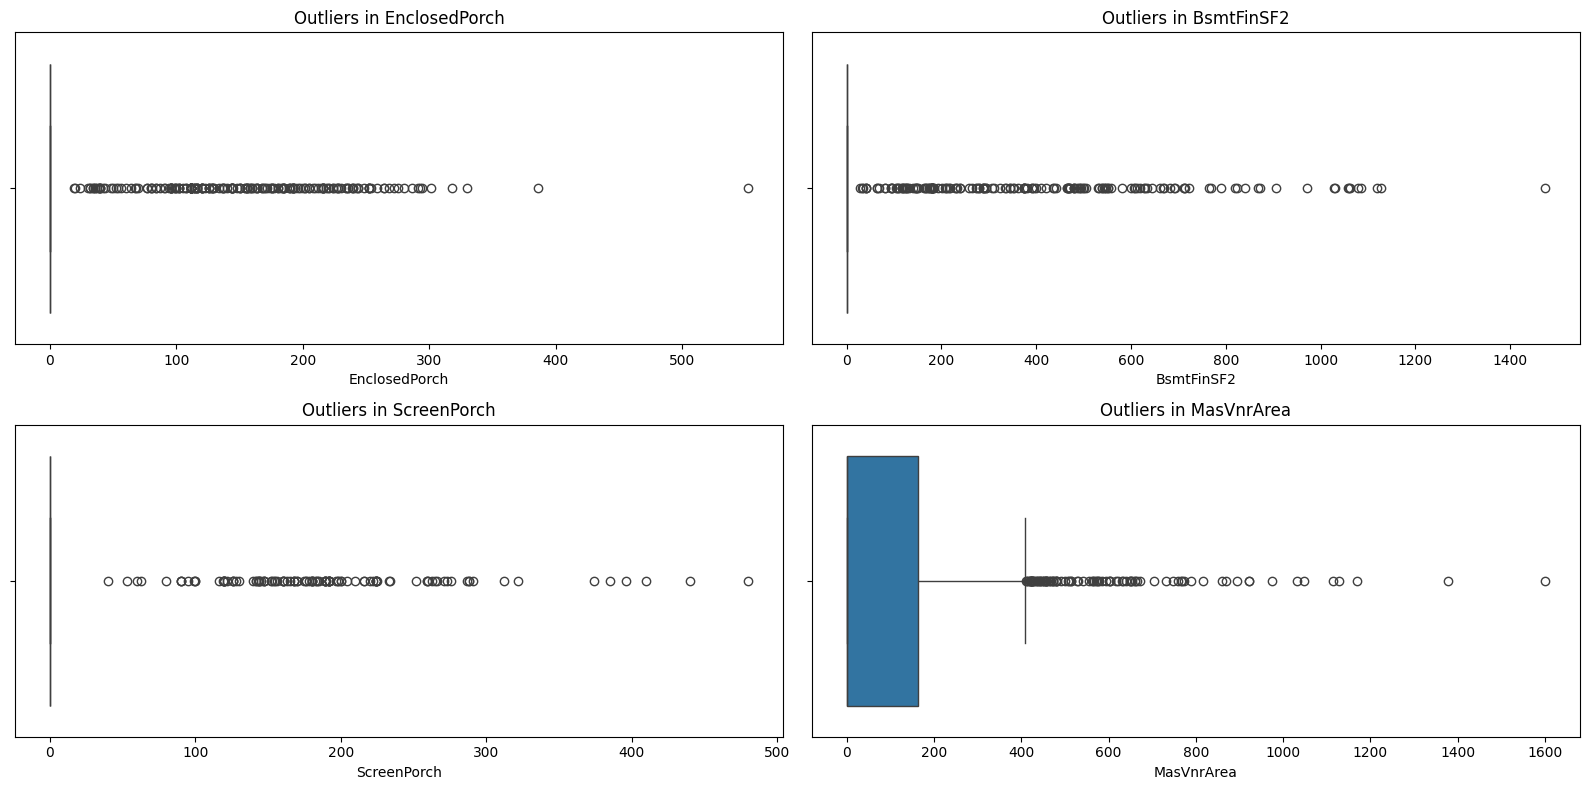

In [1783]:
# This code visualizes the distribution of your top outlier columns

# Choose the top 4 columns from your report to visualize
top_outlier_cols = outlier_report['Column'].iloc[:4].tolist()

plt.figure(figsize=(16, 8))
for i, col in enumerate(top_outlier_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=train_set[col])
    plt.title(f'Outliers in {col}')

plt.tight_layout()
plt.show()

In [1784]:
# CAP (Winsorize) the extreme tails
# We use the 99th percentile to "tame" the extreme high values

cols_to_cap = ['LotArea', 'LotFrontage', 'TotalBsmtSF', '1stFlrSF', 'MasVnrArea']

for col in cols_to_cap:
    # 1. Force conversion to numeric (NA becomes NaN) so math works
    train_numeric = pd.to_numeric(train_set[col], errors='coerce')
    test_numeric = pd.to_numeric(test_set[col], errors='coerce')
    
    # 2. Calculate the 99th percentile (quantiles ignore NaNs automatically)
    upper_limit = train_numeric.quantile(0.99)
    
    # 3. Apply the cap using the numeric series
    # np.where will preserve NaNs if we use the numeric series
    train_set[col] = np.where(train_numeric > upper_limit, upper_limit, train_numeric)
    test_set[col] = np.where(test_numeric > upper_limit, upper_limit, test_numeric)

print("Capping complete for extreme continuous variables.")

Capping complete for extreme continuous variables.


In [1785]:
# numerical columns outlier report After CAPING (checking)

continuous_cols = [col for col in train_set.select_dtypes(include=['number']).columns 
                   if train_set[col].nunique() > 25 and col != 'SalePrice']

outlier_data = []

for col in continuous_cols:
    # Calculate IQR
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define Bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = train_set[(train_set[col] < lower_bound) | (train_set[col] > upper_bound)]
    
    outlier_data.append({
        'Column': col,
        'Outlier_Count': len(outliers),
        'Percentage': f"{(len(outliers)/len(train_set))*100:.2f}%",
        'Mean_Value': train_set[col].mean(),
        'Median_Value': train_set[col].median(),
        '75%_Value': train_set[col].quantile(0.75),
        'Min_Value': train_set[col].min(),
        'Max_Value': train_set[col].max()
    })

# Display the report
outlier_report = pd.DataFrame(outlier_data).sort_values(by='Outlier_Count', ascending=False)
print(outlier_report)

           Column  Outlier_Count Percentage    Mean_Value  Median_Value  \
16  EnclosedPorch            208     14.27%     21.984225           0.0   
6      BsmtFinSF2            167     11.45%     46.613169           0.0   
17    ScreenPorch            116      7.96%     15.081619           0.0   
4      MasVnrArea             97      6.65%     99.561180           0.0   
0     LotFrontage             89      6.10%     70.682025          71.0   
15    OpenPorchSF             75      5.14%     46.245542          24.5   
1         LotArea             66      4.53%  10004.081036        9475.0   
8     TotalBsmtSF             59      4.05%   1048.914266         991.0   
14     WoodDeckSF             32      2.19%     94.084362           0.0   
7       BsmtUnfSF             29      1.99%    567.096708         477.5   
11      GrLivArea             29      1.99%   1510.465706        1461.5   
13     GarageArea             20      1.37%    472.050069         479.5   
9        1stFlrSF        

It is noticed that some columns has more the 75% of their values are zeros

In [1786]:
# Zero-Value Analysis

# 1. Identify all numerical columns
numeric_cols = train_set.select_dtypes(include=['number']).columns

# 2. Calculate zero statistics
zero_stats = []
for col in numeric_cols:
    zero_count = (train_set[col] == 0).sum()
    zero_pct = (zero_count / len(train_set)) * 100
         
    zero_stats.append({
        'Column': col,
        'Zero_Count': zero_count,
        'Zero_Percentage': round(zero_pct, 2)
    })

# 3. Create DataFrame and sort by percentage
zero_report = pd.DataFrame(zero_stats).sort_values(by='Zero_Percentage', ascending=False)

print("--- Zero Value Density Report ---")
print(zero_report[zero_report['Zero_Count'] > 0]) # Only show columns that actually have zeros

--- Zero Value Density Report ---
               Column  Zero_Count  Zero_Percentage
28          3SsnPorch        1434            98.35
14       LowQualFinSF        1432            98.22
30            MiscVal        1406            96.43
29        ScreenPorch        1342            92.04
9          BsmtFinSF2        1291            88.55
27      EnclosedPorch        1250            85.73
18           HalfBath         913            62.62
7          MasVnrArea         869            59.60
16       BsmtFullBath         856            58.71
13           2ndFlrSF         829            56.86
25         WoodDeckSF         761            52.19
21         Fireplaces         690            47.33
26        OpenPorchSF         656            44.99
8          BsmtFinSF1         467            32.03
10          BsmtUnfSF         118             8.09
33  BsmtHalfBath_is_0          82             5.62
35         Has_Garage          81             5.56
23         GarageCars          81             5.

In [1787]:
# Handling Numerical Data columns with many zero values
#
#      Zero Density (%)   Mathematical Context    Recommended Action   Goal
#      96% – 100%         Near-Zero Variance      Drop Column          Prevent overfitting on tiny samples (e.g., 3SsnPorch).
#      75% – 95%          Sparse Feature          Binarize (0 or 1)    Convert "How much?" into "Does it exist?" to strengthen the signal.
#      40% – 75%          Bi-Modal Distribution   Keep as Numeric      Preserves the scale for common but optional features (e.g., 2ndFlrSF).
#      0% – 40%           Continuous / Dense      Keep & Transform     Standard numerical handling; check for skewness later.

In [1788]:
# Drop columns with Zero Density greater than 96%

def drop_near_zero_variance(train_df, test_df, threshold=96.0):
    """
    Identifies and drops columns where the percentage of zeros 
    is greater than or equal to the specified threshold.
    """
    # 1. Calculate the percentage of zeros for each numerical column
    numeric_cols = train_df.select_dtypes(include=['number']).columns
    zero_pcts = (train_df[numeric_cols] == 0).mean() * 100
    
    # 2. Identify columns that hit the threshold
    cols_to_drop = zero_pcts[zero_pcts >= threshold].index.tolist()
    
    # 3. Drop from both dataframes
    train_df_cleaned = train_df.drop(columns=cols_to_drop)
    test_df_cleaned = test_df.drop(columns=cols_to_drop)
    
    print(f"--- Low Variance Removal (Threshold: {threshold}%) ---")
    if cols_to_drop:
        for col in cols_to_drop:
            print(f"Dropped: {col} ({round(zero_pcts[col], 2)}% zeros)")
    else:
        print("No columns met the threshold for dropping.")
        
    return train_df_cleaned, test_df_cleaned

# Execute the drop
train_set, test_set = drop_near_zero_variance(train_set, test_set)



print(f"New shape of train_set: {train_set.shape}")
print(f"New shape of test_set: {test_set.shape}")

--- Low Variance Removal (Threshold: 96.0%) ---
Dropped: LowQualFinSF (98.22% zeros)
Dropped: 3SsnPorch (98.35% zeros)
Dropped: MiscVal (96.43% zeros)
New shape of train_set: (1458, 69)
New shape of test_set: (1459, 68)


In [1789]:
# Zero-Value Analysis after drop columns with Zero Density greater than 96%

numeric_cols = train_set.select_dtypes(include=['number']).columns

zero_stats = []
for col in numeric_cols:
    zero_count = (train_set[col] == 0).sum()
    zero_pct = (zero_count / len(train_set)) * 100
            
    zero_stats.append({
        'Column': col,
        'Zero_Count': zero_count,
        'Zero_Percentage': round(zero_pct, 2)
    })

zero_report = pd.DataFrame(zero_stats).sort_values(by='Zero_Percentage', ascending=False)

print("--- Zero Value Density Report ---")
print(zero_report[zero_report['Zero_Count'] > 0]) # Only show columns that actually have zeros

--- Zero Value Density Report ---
               Column  Zero_Count  Zero_Percentage
27        ScreenPorch        1342            92.04
9          BsmtFinSF2        1291            88.55
26      EnclosedPorch        1250            85.73
17           HalfBath         913            62.62
7          MasVnrArea         869            59.60
15       BsmtFullBath         856            58.71
13           2ndFlrSF         829            56.86
24         WoodDeckSF         761            52.19
20         Fireplaces         690            47.33
25        OpenPorchSF         656            44.99
8          BsmtFinSF1         467            32.03
10          BsmtUnfSF         118             8.09
30  BsmtHalfBath_is_0          82             5.62
23         GarageArea          81             5.56
22         GarageCars          81             5.56
32         Has_Garage          81             5.56
11        TotalBsmtSF          37             2.54
16           FullBath           9             0.

In [1790]:
def binarize_sparse_columns(train_df, test_df, lower=75.0, upper=95.0):
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # 1. Use the 'True' types from your reference to identify numerical columns
    # because in the current DataFrames, some numbers are hidden as 'object'
    numeric_cols = train_set_types.select_dtypes(include=['number']).columns
    
    # Ensure we only check columns that actually exist in the current DataFrame
    numeric_cols = [col for col in numeric_cols if col in train_df.columns]
    
    # 2. Convert to numeric temporarily to calculate zero percentage
    # This handles the "NA" strings safely
    temp_train_numeric = train_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    zero_pcts = (temp_train_numeric == 0).mean() * 100
    
    # 3. Target columns within the specified range
    cols_to_binarize = zero_pcts[(zero_pcts >= lower) & (zero_pcts < upper)].index.tolist()
    
    print(f"--- Binarizing Sparse Columns ({lower}% - {upper}% zeros) ---")
    
    for col in cols_to_binarize:
        new_name = f"Has_{col}"
        
        # 4. Force numeric conversion for comparison to avoid TypeError
        train_col_numeric = pd.to_numeric(train_df[col], errors='coerce')
        test_col_numeric = pd.to_numeric(test_df[col], errors='coerce')
        
        # Convert to binary: 1 if value > 0, else 0 (NaNs become 0)
        train_df[new_name] = (train_col_numeric > 0).astype(int)
        test_df[new_name] = (test_col_numeric > 0).astype(int)
        
        # Drop the original numerical column
        train_df = train_df.drop(columns=[col])
        test_df = test_df.drop(columns=[col])
        
        print(f"Transformed: {col} -> {new_name}")
        
    return train_df, test_df

# Execute the transformation
train_set, test_set = binarize_sparse_columns(train_set, test_set)

--- Binarizing Sparse Columns (75.0% - 95.0% zeros) ---
Transformed: BsmtFinSF2 -> Has_BsmtFinSF2
Transformed: EnclosedPorch -> Has_EnclosedPorch
Transformed: ScreenPorch -> Has_ScreenPorch


In [1791]:
print(train_set.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'Fence', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'BsmtHalfBath_is_0', 'SalePrice',
       'Has

In [1792]:
print(test_set.columns)

Index(['Id', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'Fence', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'BsmtHalfBath_is_0', 'Has_Garage',
       'Has_BsmtFi

In [1793]:
# Moving 'SalePrice' column to be the last column in the train_set

cols = list(train_set.columns)
cols.remove('SalePrice')
cols.append('SalePrice')
train_set = train_set[cols]

# Check the last 10 columns to verify
print(train_set.iloc[:, -10:].columns)

Index(['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'BsmtHalfBath_is_0',
       'Has_Garage', 'Has_BsmtFinSF2', 'Has_EnclosedPorch', 'Has_ScreenPorch',
       'SalePrice'],
      dtype='object')


In [1794]:
train_set.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,MoSold,YrSold,SaleType,SaleCondition,BsmtHalfBath_is_0,Has_Garage,Has_BsmtFinSF2,Has_EnclosedPorch,Has_ScreenPorch,SalePrice
0,60,RL,65.0,8450.0,None,Reg,Lvl,Inside,Gtl,CollgCr,...,2,2008,WD,Normal,1,1,0,0,0,208500
1,20,RL,80.0,9600.0,None,Reg,Lvl,FR2,Gtl,Other,...,5,2007,WD,Normal,0,1,0,0,0,181500
2,60,RL,68.0,11250.0,None,IR1,Lvl,Inside,Gtl,CollgCr,...,9,2008,WD,Normal,1,1,0,0,0,223500
3,70,RL,60.0,9550.0,None,IR1,Lvl,Corner,Gtl,Crawfor,...,2,2006,WD,Other,1,1,0,1,0,140000
4,60,RL,84.0,14260.0,None,IR1,Lvl,FR2,Gtl,NoRidge,...,12,2008,WD,Normal,1,1,0,0,0,250000


In [1795]:
# Zero-Value Analysis after binarizing the columns with Zero Density between 75% and 95%

numeric_cols = train_set.select_dtypes(include=['number']).columns

zero_stats = []
for col in numeric_cols:
    zero_count = (train_set[col] == 0).sum()
    zero_pct = (zero_count / len(train_set)) * 100
            
    zero_stats.append({
        'Column': col,
        'Zero_Count': zero_count,
        'Zero_Percentage': round(zero_pct, 2)
    })

zero_report = pd.DataFrame(zero_stats).sort_values(by='Zero_Percentage', ascending=False)

print("--- Zero Value Density Report ---")
print(zero_report[zero_report['Zero_Count'] > 0]) # Only show columns that actually have zeros

--- Zero Value Density Report ---
               Column  Zero_Count  Zero_Percentage
31    Has_ScreenPorch        1342            92.04
29     Has_BsmtFinSF2        1291            88.55
30  Has_EnclosedPorch        1250            85.73
16           HalfBath         913            62.62
7          MasVnrArea         869            59.60
14       BsmtFullBath         856            58.71
12           2ndFlrSF         829            56.86
23         WoodDeckSF         761            52.19
19         Fireplaces         690            47.33
24        OpenPorchSF         656            44.99
8          BsmtFinSF1         467            32.03
9           BsmtUnfSF         118             8.09
27  BsmtHalfBath_is_0          82             5.62
21         GarageCars          81             5.56
22         GarageArea          81             5.56
28         Has_Garage          81             5.56
10        TotalBsmtSF          37             2.54
15           FullBath           9             0.

In [1796]:
# Numerical columns outlier report

# This code scans every continuous column and tell you exactly how many outliers it contains

# 1. Identify Continuous Columns (Numerical with many unique values)
continuous_cols = [col for col in train_set.select_dtypes(include=['number']).columns 
                   if train_set[col].nunique() > 25 and col != 'SalePrice']

outlier_data = []

for col in continuous_cols:
    # Calculate IQR
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define Bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = train_set[(train_set[col] < lower_bound) | (train_set[col] > upper_bound)]
    
    outlier_data.append({
        'Column': col,
        'Outlier_Count': len(outliers),
        'Percentage': f"{(len(outliers)/len(train_set))*100:.2f}%",
        'Mean_Value': train_set[col].mean(),
        'Median_Value': train_set[col].median(),
        '75%_Value': train_set[col].quantile(0.75),
        'Min_Value': train_set[col].min(),
        'Max_Value': train_set[col].max()
    })

# Display the report
outlier_report = pd.DataFrame(outlier_data).sort_values(by='Outlier_Count', ascending=False)
print(outlier_report)

          Column  Outlier_Count Percentage    Mean_Value  Median_Value  \
4     MasVnrArea             97      6.65%     99.561180           0.0   
0    LotFrontage             89      6.10%     70.682025          71.0   
14   OpenPorchSF             75      5.14%     46.245542          24.5   
1        LotArea             66      4.53%  10004.081036        9475.0   
7    TotalBsmtSF             59      4.05%   1048.914266         991.0   
13    WoodDeckSF             32      2.19%     94.084362           0.0   
6      BsmtUnfSF             29      1.99%    567.096708         477.5   
10     GrLivArea             29      1.99%   1510.465706        1461.5   
12    GarageArea             20      1.37%    472.050069         479.5   
8       1stFlrSF             18      1.23%   1156.148800        1086.0   
2      YearBuilt              7      0.48%   1971.218107        1972.5   
5     BsmtFinSF1              5      0.34%    438.827160         382.0   
9       2ndFlrSF              2      0

In [1797]:
# To Do : interpret the last Numerical columns outlier report and see what should we do
# Idea to do : check how much the most frequent value is repeated in each column

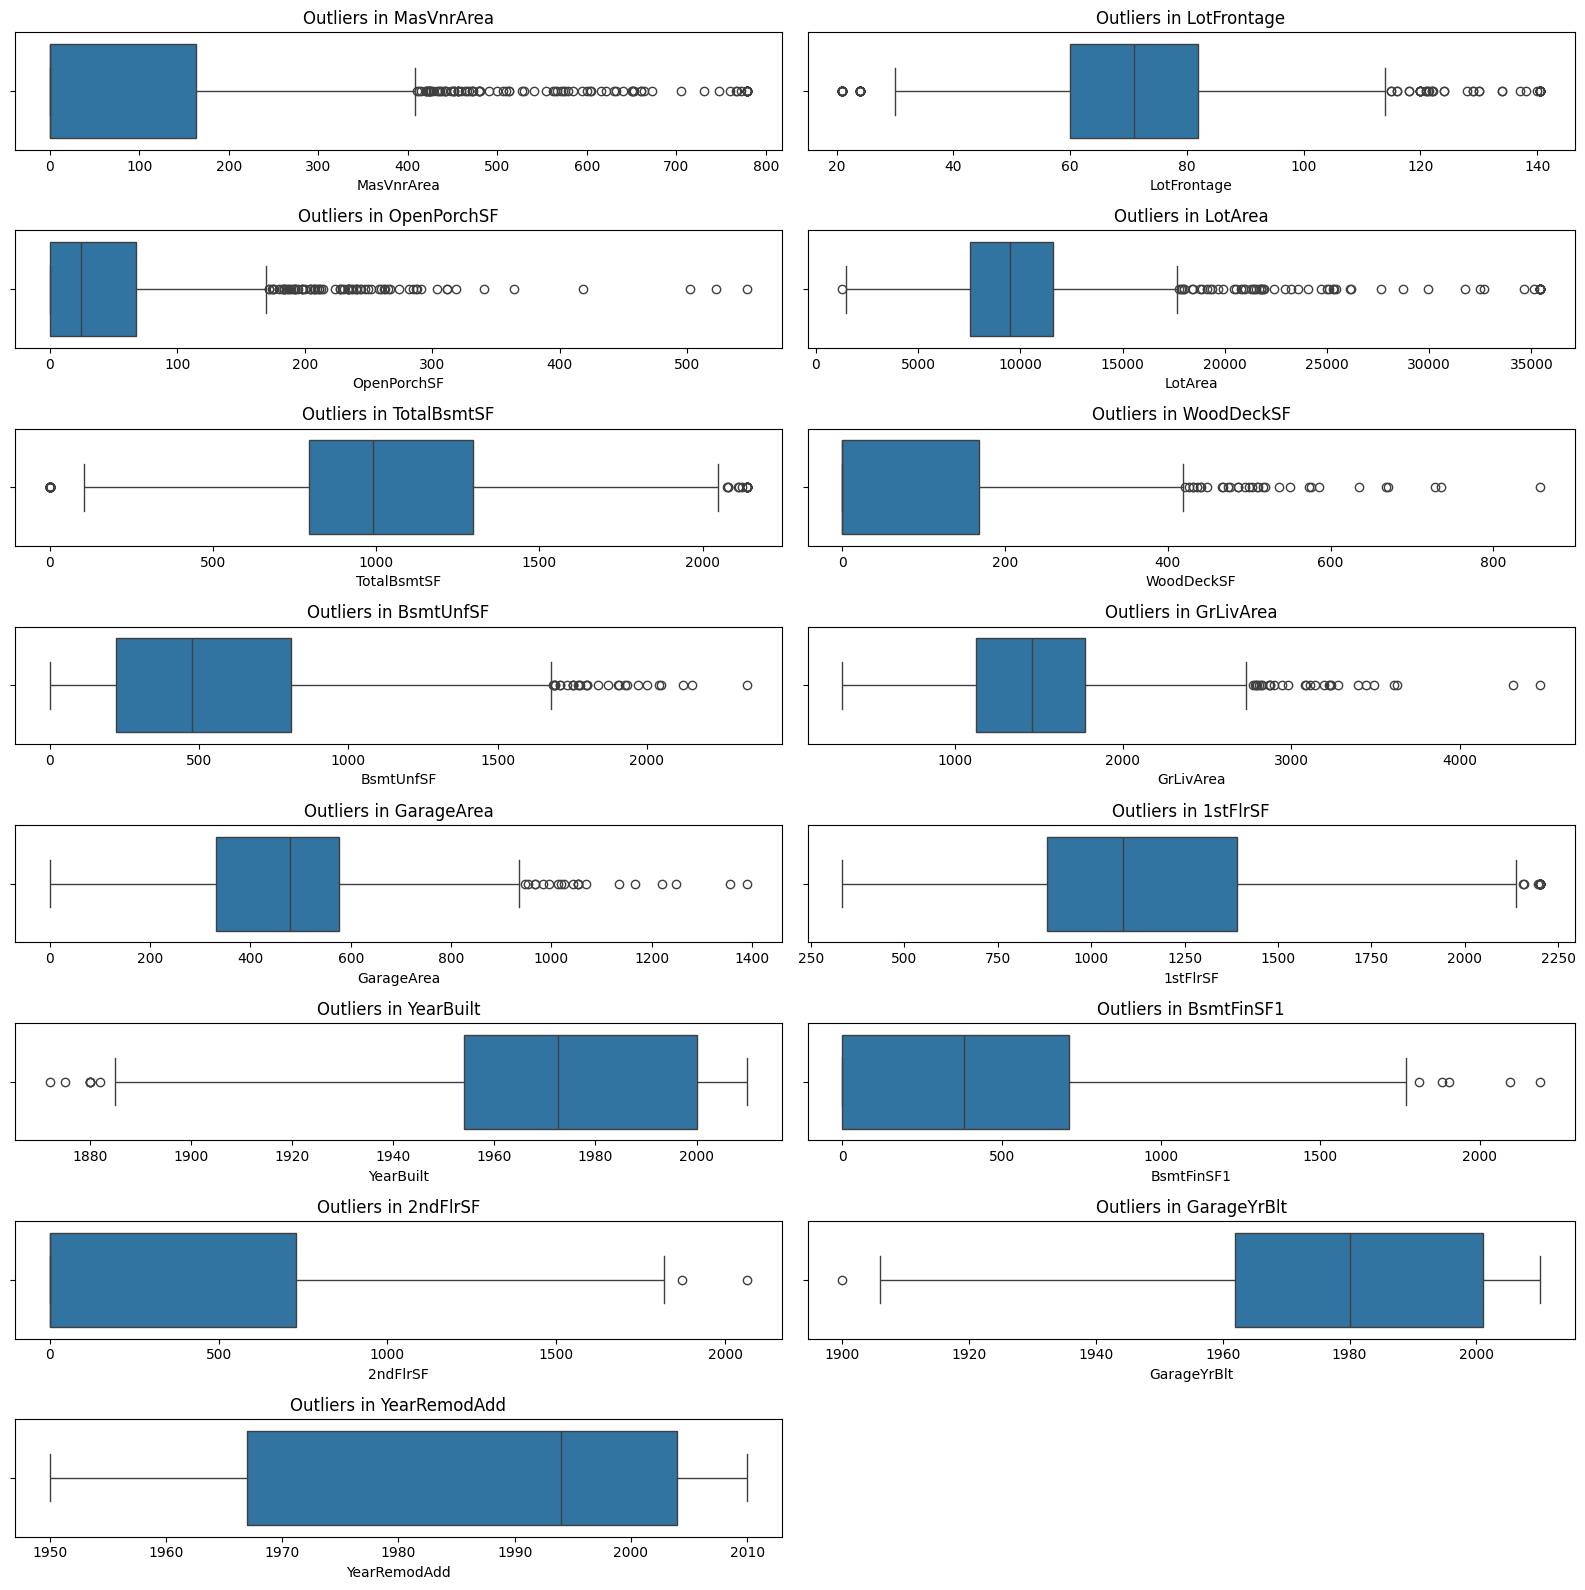

In [1798]:
# This code visualizes the distribution of your top outlier columns

top_outlier_cols = outlier_report['Column'].iloc[:].tolist()

plt.figure(figsize=(16, 16))
for i, col in enumerate(top_outlier_cols):
    plt.subplot(8, 2, i+1)
    sns.boxplot(x=train_set[col])
    plt.title(f'Outliers in {col}')

plt.tight_layout()
plt.show()